In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the csv file
userlog = pd.read_csv('user_logs.csv')
# Set datetime object as the index
userlog = userlog.set_index(userlog.datetime)
# Drop the original datetime column
userlog.drop(columns='datetime',inplace=True)

In [3]:
# Set 'datetime' as a datetime index.
userlog.index = pd.to_datetime(userlog.index)

In [4]:
# Verify index was set.
userlog.index

DatetimeIndex(['2018-01-26 09:55:03', '2018-01-26 09:56:02',
               '2018-01-26 09:56:05', '2018-01-26 09:56:06',
               '2018-01-26 09:56:24', '2018-01-26 09:56:41',
               '2018-01-26 09:56:46', '2018-01-26 09:56:48',
               '2018-01-26 09:56:59', '2018-01-26 09:58:26',
               ...
               '2021-04-21 16:38:14', '2021-04-21 16:41:29',
               '2021-04-21 16:41:31', '2021-04-21 16:41:49',
               '2021-04-21 16:41:51', '2021-04-21 16:41:51',
               '2021-04-21 16:42:02', '2021-04-21 16:42:09',
               '2021-04-21 16:44:37', '2021-04-21 16:44:39'],
              dtype='datetime64[ns]', name='datetime', length=847330, freq=None)

In [5]:
len(userlog.cohort_name.value_counts())

47

In [6]:
len(userlog.slack.value_counts())

46

In [7]:
userlog.cohort_name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Darden        32015
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Bayes         26538
Wrangell      25586
Andromeda     25359
Kalypso       23691
Curie         21582
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Easley        14715
Lassen         9587
Arches         8890
Florence       8562
Sequoia        7444
Neptune        7276
Olympic        4954
Kings          2845
Pinnacles      2158
Hampton        1712
Oberon         1672
Quincy         1237
Niagara         755
Mammoth         691
Glacier         598
Joshua          302
Ike             253
Badlands         93
Franklin         72
Apollo            5
Denali            4
Everglades        1
Name: cohort_name, dtype: int64

In [8]:
userlog.slack.value_counts()

#              110569
#ceres          40730
#zion           38096
#jupiter        37109
#fortuna        36902
#voyageurs      35636
#ganymede       33844
#apex           33568
#deimos         32888
#darden         32015
#teddy          30926
#hyperion       29855
#betelgeuse     29356
#ulysses        28534
#europa         28033
#xanadu         27749
#wrangell       25586
#andromeda      25359
#kalypso        23691
#curie          21582
#yosemite       20743
#bash           17713
#luna           16623
#marco          16397
#easley         14715
#lassen          9587
#arches          8890
#florence        8562
#sequoia         7444
#neptune         7276
#olympic         4954
#kings           2845
#pinnacles       2158
#hampton         1712
#oberon          1672
#quincy          1237
#niagara          755
#mammoth          691
#glacier          598
#joshua           302
#ike              253
#badlands          93
#franklin          72
#apollo             5
#denali             4
#everglade

# Takeaways
* Bayes is missing a slack channel
* They may have been put in the '#' slack channel.
* **update** The Bayes cohort was put into the '#' slack channel.

In [9]:
# Convert all datetime values into datetime datatype
userlog.end_date = pd.to_datetime(userlog.end_date)
userlog.start_date = pd.to_datetime(userlog.start_date)
userlog.created_at = pd.to_datetime(userlog.created_at)
userlog.updated_at = pd.to_datetime(userlog.updated_at)

In [10]:
# Drop 'deleted_at' column
userlog.drop(columns='deleted_at', inplace=True)

In [11]:
userlog.path.value_counts()

/                                                  45854
javascript-i                                       18203
toc                                                17591
search/search_index.json                           17534
java-iii                                           13166
                                                   ...  
.git                                                   1
quiz118                                                1
'                                                      1
content/examples/git/gitbook/images/favicon.ico        1
content/html-css/forms-i/index.html                    1
Name: path, Length: 2224, dtype: int64

# Takeaways
* 2224 different paths were accessed.

In [12]:
userlog.path.apply(type).value_counts()

<class 'str'>      847329
<class 'float'>         1
Name: path, dtype: int64

# Takeaways
* There is one observtion that is a float datatype that is screwing everything up.

In [13]:
# Drop nan values(there is only one)
userlog.dropna(inplace=True)

In [14]:
# Split the 'path' column at the backslash
userlog['path_split'] = userlog.path.str.split('/')

In [15]:
# Create a new column for module name and lesson
userlog['module'] = [mod[0] for mod in userlog.path_split]
# Create a second item for the lists that only have one time
for mod in userlog.path_split:    
    if len(mod) == 1:
        mod = mod.append('')

userlog['lesson'] = [mod[1] for mod in userlog.path_split]

# Takeaways
* The dataframe is wrangled and now ready for exploration.

In [16]:
userlog.index.min(), userlog.index.max()

(Timestamp('2018-01-26 09:55:03'), Timestamp('2021-04-21 16:44:39'))

In [17]:
userlog.program_id.value_counts()

2    713365
3    103411
1     30548
4         5
Name: program_id, dtype: int64

In [18]:
userlog[userlog.program_id == 4].lesson.value_counts().head(50)

html-css    4
            1
Name: lesson, dtype: int64

In [19]:
userlog['program'] = userlog.program_id.map(
    {
        1.0: 'Full-Stack PHP',
        2.0: 'Full-Stack Java',
        3.0: 'Data Science',
        4.0: 'Front-End'
    })

In [20]:
userlog[userlog.program_id == 4]

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program
datetime,,,,,,,,,,,,,,,
2018-03-22 19:01:49,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,/,152,207.68.209.17,"[, ]",,,Front-End
2018-03-22 19:01:54,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css,152,207.68.209.17,"[content, html-css]",content,html-css,Front-End
2018-03-22 19:01:54,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css/gitbook/images/favicon.ico,152,207.68.209.17,"[content, html-css, gitbook, images, favicon.ico]",content,html-css,Front-End
2018-03-22 19:02:47,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css,152,207.68.209.17,"[content, html-css]",content,html-css,Front-End
2018-03-22 19:02:52,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css/introduction.html,152,207.68.209.17,"[content, html-css, introduction.html]",content,html-css,Front-End


### At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


In [21]:
pd.set_option('display.max_rows', 3000)

In [22]:
userlog['ds_student'] = userlog.program_id == 3

In [23]:
# Print out a list of the unique paths visited by Web Development students.
list(userlog[userlog.ds_student == False].path.unique())

['/',
 'java-ii',
 'java-ii/object-oriented-programming',
 'slides/object_oriented_programming',
 'javascript-i/conditionals',
 'javascript-i/loops',
 'javascript-i/functions',
 'mkdocs/search_index.json',
 'javascript-i/introduction/working-with-data-types-operators-and-variables',
 'javascript-i',
 'javascript-i/introduction/variables',
 'javascript-i/introduction/operators',
 'git/merge-conflict-demo',
 'git/working-in-teams',
 'javascript-i/introduction/primitive-types',
 'javascript-i/javascript-with-html',
 'spring',
 'appendix',
 'spring/extra-features/file-upload',
 'appendix/capstone-workbook',
 'javascript-i/objects/math',
 'index.html',
 'java-i',
 'appendix/further-reading/javascript/hoisting.html',
 'html-css/introduction',
 'javascript-i/bom-and-dom',
 'javascript-i/bom-and-dom/bom',
 'examples/javascript/defuse-the-bom.html',
 'javascript-i/introduction',
 'javascript-i/bom-and-dom/dom',
 'examples/javascript/dom-query-js.html',
 'spring/fundamentals/security/authenticat

In [24]:
# Show list of unique paths visited by Data Science students.
list(userlog[userlog.ds_student == True].path.unique())

['/',
 '3-sql/1-mysql-overview',
 '2-storytelling/bad-charts',
 '2-storytelling/misleading1_baseball.jpg',
 '2-storytelling/misleading1_fox.jpg',
 '2-storytelling/misleading3_deaths.jpg',
 'appendix/cli-git-overview',
 '1-fundamentals/1.1-intro-to-data-science',
 '1-fundamentals/modern-data-scientist.jpg',
 '1-fundamentals/AI-ML-DL-timeline.jpg',
 '1-fundamentals/1.2-data-science-pipeline',
 '1-fundamentals/DataToAction_v2.jpg',
 'search/search_index.json',
 '13-advanced-topics/3.7-styling-webpages',
 '1-fundamentals/1.3-pipeline-demo',
 '1-fundamentals/2.1-excel-overview',
 '3-vocabulary.md',
 '6-regression/1-overview',
 '10-anomaly-detection/1-overview',
 '10-anomaly-detection/AnomalyDetectionCartoon.jpeg',
 '11-nlp/1-overview',
 '6-regression/2-regression-excel',
 '6-regression/3.1-acquire-and-prep',
 '6-regression/3.2-split-and-scale',
 '6-regression/3.3-explore',
 '6-regression/3.4-feature-engineering',
 '6-regression/3.5-modeling',
 '6-regression/3.6-evaluation',
 '6-regression/e

In [25]:
# Save list for Data Science students.
datascience = list(userlog[userlog.ds_student == True].module.unique())

In [26]:
# Save list for Web Development students.
webdev = list(userlog[userlog.ds_student == False].module.unique())

In [27]:
len(datascience), len(webdev)

(153, 610)

In [28]:
# Conver lists into sets.
set_datascience = set(datascience)
set_webdev = set(webdev)

In [29]:
# Create a set that contains the paths that both Web Development students and Data Science students
# are accessing.
set1 = set_webdev.intersection(set_datascience)

In [30]:
set_datascience

{'',
 '%20https:',
 ',%20https:',
 '.gitignore',
 '1-fundamentals',
 '1-overview',
 '1.2-data-science-pipeline',
 '1.3-pipeline-demo',
 '10-anomaly-detection',
 '11-nlp',
 '12-distributed-ml',
 '13-advanced-topics',
 '13.1_Understand',
 '2-storytelling',
 '2.1-spreadsheets-overview',
 '3-acquire',
 '3-data-types-and-variables',
 '3-databases',
 '3-discrete-probabilistic-methods',
 '3-probability-distributions',
 '3-sql',
 '3-vocabulary',
 '3-vocabulary.md',
 '4-detecting-timeseries-anomalies',
 '4-python',
 '4.2-compare-means',
 '4.5-more-statistical-testing-examples',
 '5-detecting-with-clustering',
 '5-stats',
 '6-regression',
 '7-classification',
 '7.4.1-pandas-overview',
 '7.4.2-series',
 '8-clustering',
 '9-timeseries',
 'A-clustering',
 'AI-ML-DL-timeline.jpg',
 'AnomalyDetectionCartoon.jpeg',
 'DataToAction_v2.jpg',
 'End_to_End_clustering',
 'Hospital-Distance-Clusters.jpg',
 'Index.html',
 'Pipeline_Demo',
 'Selecting_a_hypothesis_test.svg',
 'acquire',
 'acquire-and-prep',
 '

In [31]:
# Check the amount of visits to the '6-regression' path for Data Science students.
(userlog[userlog.ds_student == True].module == '6-regression').sum()

4562

In [32]:
# Check the amount of visits to the '6-regression' path for Web Development students.
(userlog[userlog.ds_student == False].module == '6-regression').sum()

1283

In [33]:
set1

{'',
 '.gitignore',
 '1-fundamentals',
 '10-anomaly-detection',
 '11-nlp',
 '12-distributed-ml',
 '13-advanced-topics',
 '13.1_Understand',
 '2-storytelling',
 '3-sql',
 '3-vocabulary.md',
 '4-python',
 '5-stats',
 '6-regression',
 '7-classification',
 '8-clustering',
 '9-timeseries',
 'AI-ML-DL-timeline.jpg',
 'AnomalyDetectionCartoon.jpeg',
 'Hospital-Distance-Clusters.jpg',
 'Pipeline_Demo',
 'acquire',
 'advanced-topics',
 'alumni',
 'anomaly-detection',
 'appendix',
 'basic-statements',
 'capstones',
 'classification',
 'clustering',
 'create',
 'curie-python-assessment',
 'darden-python-assessment.html',
 'database-design',
 'databases',
 'dataframes',
 'distributed-ml',
 'examples',
 'explore',
 'florence-python-assessment.html',
 'functions',
 'fundamentals',
 'git',
 'grades',
 'group-by',
 'html-css',
 'index.html',
 'individual-project',
 'java-i',
 'java-ii',
 'java-iii',
 'javascript-i',
 'javascript-ii',
 'jquery',
 'login',
 'misleading1_baseball.jpg',
 'misleading1_fox.

### Create a for loop that will compare the amount of visits to a certain path. Append the path to the correct list.

In [34]:
ds_path = []
webdev_path = []
for path in set1:
    if (userlog[userlog.ds_student == True].module == path).sum() > (userlog[userlog.ds_student == False].module == path).sum():
        ds_path.append(path)
    else:
        webdev_path.append(path)

In [35]:
# Verify length of set1.
len(set1)

76

In [36]:
len(ds_path), len(webdev_path)

(42, 34)

## Based on domain knowledge, verify if paths belong to Data Science curriculum.

In [37]:
ds_path

['timeseries',
 'nlp',
 'classification',
 'distributed-ml',
 '8-clustering',
 '11-nlp',
 '5-stats',
 '9-timeseries',
 'pandas-overview',
 'dataframes',
 'AI-ML-DL-timeline.jpg',
 'anomaly-detection',
 'fundamentals',
 'overview',
 '7-classification',
 '13-advanced-topics',
 '2-storytelling',
 'series',
 'darden-python-assessment.html',
 '10-anomaly-detection',
 'clustering',
 'explore',
 'curie-python-assessment',
 '6-regression',
 'acquire',
 'user-defined-functions.md',
 '3-sql',
 'individual-project',
 'advanced-topics',
 'modern-data-scientist.jpg',
 'regression',
 'storytelling',
 '4-python',
 '1-fundamentals',
 'capstones',
 'working-with-time-series-data',
 'stats',
 '12-distributed-ml',
 'florence-python-assessment.html',
 'create',
 'sql',
 'python']

# Takeaways
* Everything seems to check out for me. I will need a Data Science curriculum expert to verify.

In [38]:
userlog

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program,ds_student
datetime,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,/,1,97.105.19.61,"[, ]",,,Full-Stack PHP,False
2018-01-26 09:56:02,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii,1,97.105.19.61,"[java-ii, ]",java-ii,,Full-Stack PHP,False
2018-01-26 09:56:05,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii/object-oriented-programming,1,97.105.19.61,"[java-ii, object-oriented-programming]",java-ii,object-oriented-programming,Full-Stack PHP,False
2018-01-26 09:56:06,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,slides/object_oriented_programming,1,97.105.19.61,"[slides, object_oriented_programming]",slides,object_oriented_programming,Full-Stack PHP,False
2018-01-26 09:56:24,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/conditionals,2,97.105.19.61,"[javascript-i, conditionals]",javascript-i,conditionals,Full-Stack Java,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/personal-site,64,71.150.217.33,"[jquery, personal-site]",jquery,personal-site,Full-Stack Java,False
2021-04-21 16:42:02,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/mapbox-api,64,71.150.217.33,"[jquery, mapbox-api]",jquery,mapbox-api,Full-Stack Java,False
2021-04-21 16:42:09,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/ajax/weather-map,64,71.150.217.33,"[jquery, ajax, weather-map]",jquery,ajax,Full-Stack Java,False


## Based on domain knowledge, verify if paths belong to Web Development curriculum.

In [39]:
webdev_path

['',
 'java-i',
 'login',
 'java-ii',
 'javascript-ii',
 'misleading1_fox.jpg',
 'appendix',
 'mkdocs',
 'mysql',
 'basic-statements',
 'examples',
 'index.html',
 'Hospital-Distance-Clusters.jpg',
 'search',
 'databases',
 'html-css',
 'java-iii',
 'misleading1_baseball.jpg',
 'misleading3_deaths.jpg',
 'git',
 'grades',
 'jquery',
 '.gitignore',
 'Pipeline_Demo',
 '13.1_Understand',
 'spring',
 '3-vocabulary.md',
 'AnomalyDetectionCartoon.jpeg',
 'group-by',
 'toc',
 'database-design',
 'functions',
 'javascript-i',
 'alumni']

# Takeaways
* There are a couple of items that may be from the Data Science curriculum, but they are just images.

In [40]:
# Convert newly created list into a set.
ds_path = set(ds_path)

In [41]:
# Convert newly created list into a set.
webdev_path = set(webdev_path)

In [42]:
# Check lengths to use for verification later.
len(set_datascience), len(webdev_path), len(set_datascience)-len(webdev_path)

(153, 34, 119)

In [46]:
# Create a new set for Data Science paths only.
datascience_paths = set_datascience.difference(webdev_path)

In [47]:
# Create a new set for Web Development paths only.
webdev_paths = set_webdev.difference(ds_path)

In [48]:
userlog[userlog.ds_student == True].module == datascience_paths

datetime
2019-08-20 09:39:58    False
2019-08-20 09:39:59    False
2019-08-20 09:39:59    False
2019-08-20 09:40:02    False
2019-08-20 09:40:08    False
                       ...  
2021-04-21 16:14:16    False
2021-04-21 16:15:51    False
2021-04-21 16:23:53    False
2021-04-21 16:23:57    False
2021-04-21 16:32:50    False
Name: module, Length: 103411, dtype: bool

In [49]:
data_science_hits = userlog[userlog.module.isin(datascience_paths)]

In [50]:
webdev_hits = userlog[userlog.module.isin(webdev_paths)]

In [51]:
len(data_science_hits), len(webdev_hits), len(data_science_hits)+len(webdev_hits)

(110980, 736349, 847329)

In [61]:
# Create a dataframe of all Data Science curriculum hits that are from Web Development students.
webdev_ds_hits = data_science_hits[data_science_hits.ds_student == False]

In [65]:
webdev_ds_hits.shape[0]

22238

In [77]:
# Create a dataframe of all Web Development curriculum hits that are from Web Development students.
webdev_webdev_hits = webdev_hits[webdev_hits.ds_student == False]

In [78]:
webdev_webdev_hits.shape[0]

721680

## Resample each Web Development dataframe by day and plot activity.

<AxesSubplot:xlabel='datetime'>

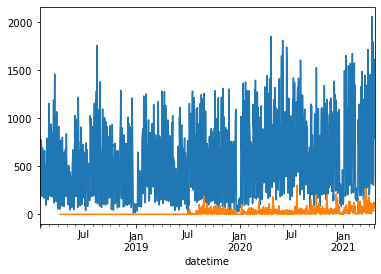

In [90]:
(webdev_webdev_hits.resample('d').path.count()).plot()
(webdev_ds_hits.resample('d').path.count()).plot()

In [67]:
# Create a dataframe of all Data Science curriculum hits that are from Data Science students.
ds_ds_hits = data_science_hits[data_science_hits.ds_student == True]

In [69]:
ds_ds_hits.shape[0]

88742

In [70]:
# Create a dataframe of all Web Development curriculum hits that are from Data Science students.
ds_webdev_hits = webdev_hits[webdev_hits.ds_student == True]

In [72]:
ds_webdev_hits.shape[0]

14669

In [79]:
# Verify all added together equals total
webdev_ds_hits.shape[0]+webdev_webdev_hits.shape[0]+ds_ds_hits.shape[0]+ds_webdev_hits.shape[0]

847329

## Resample each Data Science dataframe by day and plot activity.

<AxesSubplot:xlabel='datetime'>

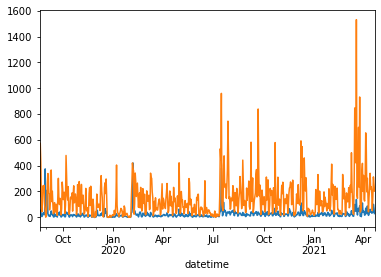

In [91]:
(ds_webdev_hits.resample('d').path.count()).plot()
(ds_ds_hits.resample('d').path.count()).plot()

### Check to see which webpages the Data Science students are visiting

In [ ]:
userlog[userlog.ds_student == True].module.value_counts()[:50]

In [ ]:
userlog[userlog.ds_student == True].module.value_counts()[50:100]

# Takeaways
* The Data Science students during the time this data was captured did not visit many Web Development pages.

In [ ]:
# Check the number of users in this dataset.
userlog.ip.unique().shape[0]

### Check to see which webpages the Web Development students are visiting.

In [ ]:
userlog[userlog.ds_student == False].module.value_counts()[:50]

In [ ]:
userlog[userlog.ds_student == False].module.value_counts()[50:100]

In [ ]:
userlog[userlog.ds_student == False].module.value_counts()[100:150]

# Takeaways
* The Web Development students visited Data Science webpages a lot more than Data Science students visited Web Development pages.

### Resample the data by day and plot number of page visits/day for Web Development students.

In [53]:
web_dev_page_visits = userlog[userlog.ds_student == False].resample('d').path.count()

<AxesSubplot:xlabel='datetime'>

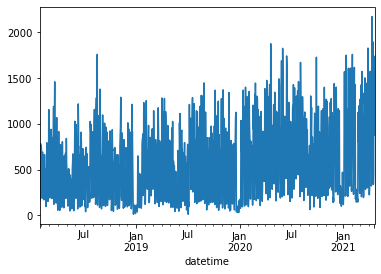

In [54]:
web_dev_page_visits.plot()

## Use Bolinger Bands to set upper and lower limits for normal activity. This method will be used to identify abnormal page visits.

### Set Midband

#### The Exponential Moving Average

In [ ]:
# Compute the midband.
midband = web_dev_page_visits.ewm(span=30).mean()

In [ ]:
midband.plot()

## Set Upper & Lower Band

UB/LB = Midband +/- stdev * K

In [ ]:
# Compute the exponential standard deviation.
stdev = web_dev_page_visits.ewm(span=30).std()

In [ ]:
# Compute the upper and lower bands.
ub = midband + stdev*2
lb = midband - stdev*2
ub, lb

In [ ]:
# Concatenate upper band and lower band together into one dataframe, bb.
bb = pd.concat([ub, lb], axis=1)
# Set names of columns.
bb.columns = ['ub', 'lb']

# Create a dataframe that holds the values for 'pages', 'midband', and the newly created 'bb'.
my_df = pd.concat([web_dev_page_visits, midband, bb], axis=1)
my_df.columns = ['web_dev_page_visits', 'midband', 'ub', 'lb']
my_df.head()

## Plot number of page visits along with the Bollinger Bands

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.web_dev_page_visits, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [ ]:
# A list of the amount of page visits for each cohort
userlog[userlog.ds_student == False].cohort_name.value_counts()

### Plot the distribution of page visits for Web Development students.

In [ ]:
userlog[userlog.ds_student == False].cohort_name.value_counts().hist()

In [ ]:
userlog[userlog.ds_student == False].cohort_name.value_counts().mean()

In [ ]:
userlog[userlog.ds_student == False].cohort_name.value_counts() > 10000

In [ ]:
userlog.resample('d').path.count()